In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, activations
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
train_df = pd.read_csv('train_1Dx.csv',nrows=1000000)
test_df = pd.read_csv('test_1Dx.csv',nrows=50000)

In [3]:
X_train = train_df.drop(columns=['x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['x-midplane','cotAlpha']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [5]:
def custom_loss(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = tf.gather(params=p, indices=[1], axis=1)
        
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(tf.math.multiply_no_nan(likelihood,tf.cast(sigma>0,tf.float32)),minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [6]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    #x = BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(2, name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(),
              loss=custom_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                1408      
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 dense2 (Dense)              (None, 2)                 130       
                                                                 
Total params: 1,538
Trainable params: 1,538
Non-trainable params: 0
_________________________________________________________________


2022-11-02 18:40:22.735497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 18:40:22.771844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 18:40:22.772171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 18:40:22.773108: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [7]:
es = EarlyStopping(patience=10)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=80, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/80
  109/12500 [..............................] - ETA: 17s - loss: 20.3705  

2022-11-02 18:40:25.178548: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


12500/12500 [==============================] - 22s 2ms/step - loss: 4.3773 - val_loss: 3.4003
Epoch 2/80
12500/12500 [==============================] - 20s 2ms/step - loss: 3.3466 - val_loss: 3.3090
Epoch 3/80
12500/12500 [==============================] - 21s 2ms/step - loss: 3.2928 - val_loss: 3.2764
Epoch 4/80
12500/12500 [==============================] - 20s 2ms/step - loss: 3.2664 - val_loss: 3.2550
Epoch 5/80
12500/12500 [==============================] - 21s 2ms/step - loss: 3.2492 - val_loss: 3.2412
Epoch 6/80
12500/12500 [==============================] - 22s 2ms/step - loss: 3.2370 - val_loss: 3.2301
Epoch 7/80
12500/12500 [==============================] - 22s 2ms/step - loss: 3.2265 - val_loss: 3.2197
Epoch 8/80
12500/12500 [==============================] - 21s 2ms/step - loss: 3.2177 - val_loss: 3.2150
Epoch 9/80
12500/12500 [==============================] - 22s 2ms/step - loss: 3.2096 - val_loss: 3.2031
Epoch 10/80
12500/12500 [==============================] - 22s 2ms

/tmp/ipykernel_162582/3321773974.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


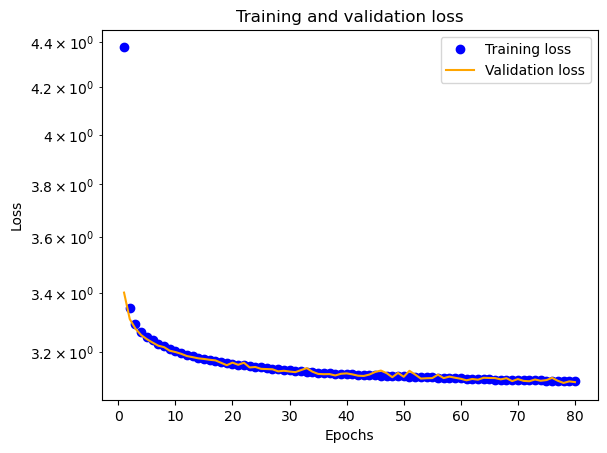

In [8]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
plt.show()

In [9]:
model.save('models_1Dx/gauss.keras')

In [10]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['xtrue'] = y_test
df.to_csv("test_1DxGauss.csv",header=False,index=False)

In [11]:
residuals = y_test - p_test[:,0]
print(np.mean(residuals),np.std(residuals))

-0.6535411046935804 6.542802489201545


In [12]:
uncertainty= p_test[:,1]
print(np.mean(uncertainty),np.std(uncertainty))

5.0131083 2.2391734


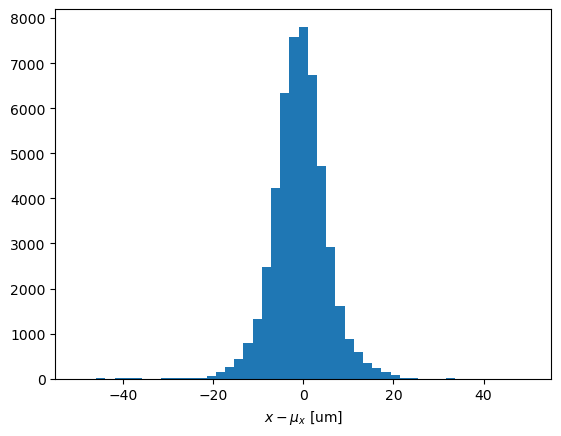

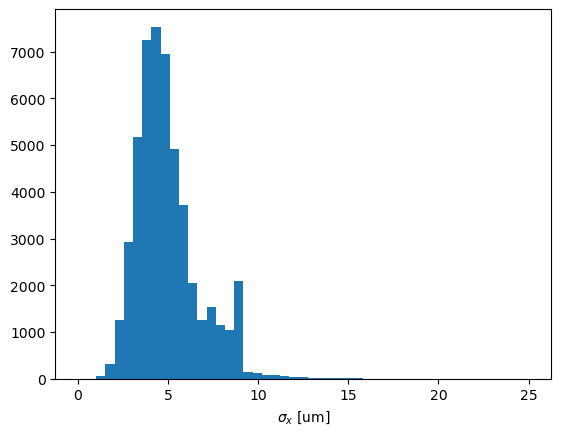

In [13]:
plt.hist(residuals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.show()

plt.hist(uncertainty,bins=np.linspace(0,25,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

In [14]:
pulls = residuals/p_test[:,1]

Text(0.5, 0, 'pull')

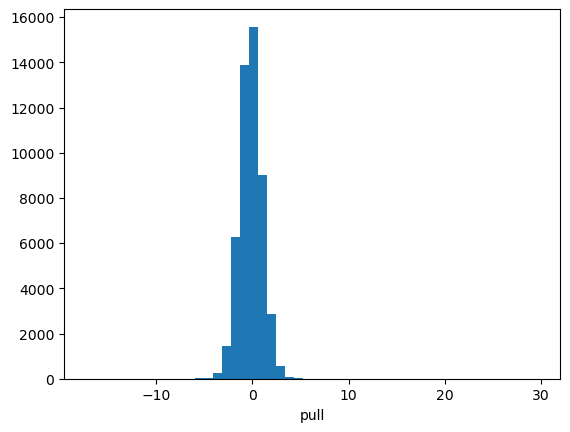

In [15]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [16]:
print(np.mean(pulls),np.std(pulls))

-0.15140079302961018 1.189021947948037
